In [1]:
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import PIL.Image
from torchvision.utils import make_grid # to plot

In [2]:
from data import RawWaterMeterDS
from utils import coordinate_rotation_transform, show, TrainVisualizer

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
DS = RawWaterMeterDS()
train_ds, valid_ds = data.random_split(DS, [0.8, 0.2])

torch.Size([3, 960, 540])

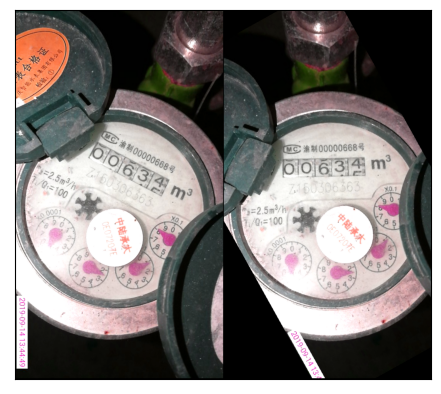

In [5]:
# default RawDataset return (img, rotated angles)
img, ang = DS[2]
show(make_grid([img, transforms.RandomRotation([ang * 90, ang * 90])(img)]))
DS[2][0].shape

In [6]:
from models.rotation_regression_network import rota_reg_net_resnet18
net = rota_reg_net_resnet18()

In [7]:
from utils import tuple_collate_fn
train_dl = data.DataLoader(train_ds, 16, True, collate_fn=tuple_collate_fn)
valid_dl = data.DataLoader(valid_ds, 16, False, collate_fn=tuple_collate_fn)

In [7]:
optim = torch.optim.Adam(net.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95)
visualizer = TrainVisualizer()

----START TRAINING----
epoch 1:
    iter: 20 train_loss: 0.12293691150844097
    iter: 40 train_loss: 0.13062049858272076

    ERROR<= 10° RATE: 56.5%, ERROR<= 5°  RATE: 26.2%


    ERROR<= 10° RATE: 56.0%, ERROR<= 5°  RATE: 33.5%

epoch 2:
    iter: 70 train_loss: 0.11690299175679683
    iter: 90 train_loss: 0.12098632454872131

    ERROR<= 10° RATE: 55.0%, ERROR<= 5°  RATE: 28.1%


    ERROR<= 10° RATE: 53.0%, ERROR<= 5°  RATE: 29.0%

-----END TRAINING-----
1
2
2


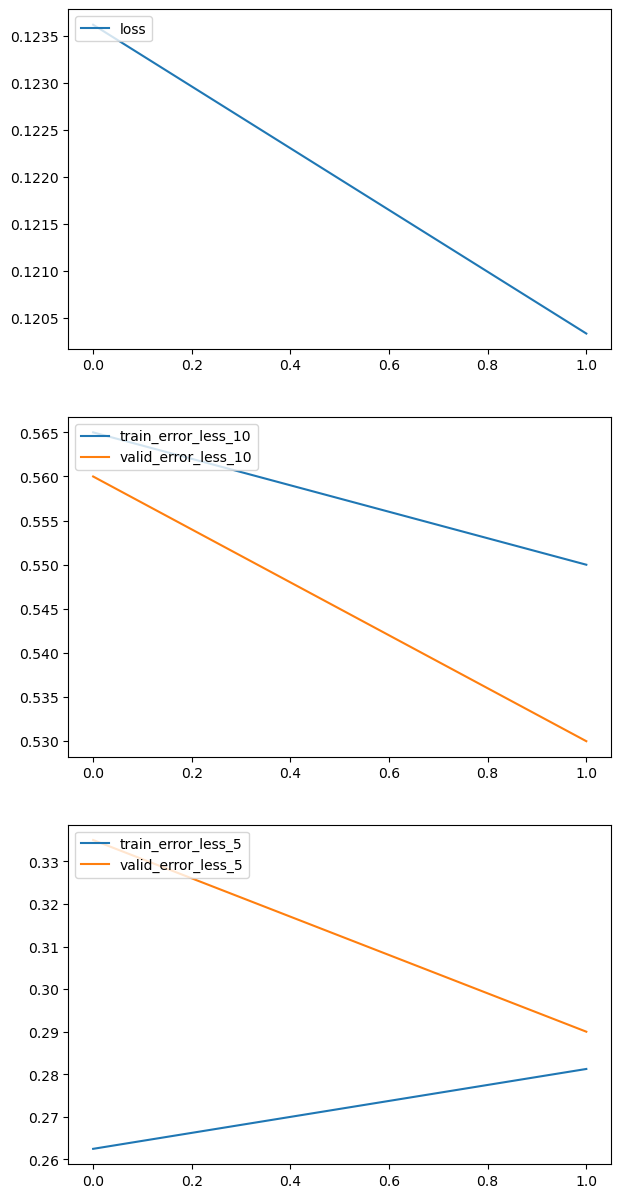

In [12]:
net.to(device)
visualizer.reset()
num_epochs = 20

# test model precision
def test_reg_precision(test_model, dataloader, total_num):
    with torch.no_grad():
        test_model.eval()
        num_less_5, num_less_10 = 0, 0
        for X, y in dataloader:
            res = torch.abs(net(X, y) - torch.cat(y, dim=0).to(device) * 90)
            num_less_10 += (res < 10.0).sum()
            num_less_5 += (res < 5.0).sum()

        print(f'\n    ERROR<= 10° RATE: {100 * num_less_10 / total_num:.1f}%, '
              f'ERROR<= 5°  RATE: {100 * num_less_5 / total_num:.1f}%')
        return num_less_10 / total_num, num_less_5 / total_num

print('----START TRAINING----')
for epoch in range(num_epochs):
    epoch_loss = 0
    net.train()
    mean_loss = 0
    print(f'\nepoch {epoch + 1}:')
    for i, (X, y) in enumerate(train_dl):
        optim.zero_grad()
        loss_dict, _ = net(X, y)
        loss = loss_dict['mae_loss']
        mean_loss += loss.item()
        epoch_loss += loss.item()

        if (i + 1) % 20 == 0:
            print(f'    iter: {epoch * len(train_dl) + i + 1} train_loss: {mean_loss / 20}')
            mean_loss = 0
        loss.backward()
        optim.step()
        lr_scheduler.step()

    train_error_les10, train_error_les5 = test_reg_precision(net, train_dl, len(train_ds))
    valid_error_les10, valid_error_les5 = test_reg_precision(net, valid_dl, len(valid_ds))
    visualizer.record(**{
        'epoch': epoch,
        'loss': epoch_loss / len(train_dl),
        'train_error_less_10': train_error_les10.cpu().item(),
        'train_error_less_5': train_error_les5.cpu().item(),
        'valid_error_less_10': valid_error_les10.cpu().item(),
        'valid_error_less_5': valid_error_les5.cpu().item(),
    })
print('-----END TRAINING-----')
visualizer.visualize(
    'epoch', ['loss', ['train_error_less_10', 'valid_error_less_10'], ['train_error_less_5', 'valid_error_less_5']]
)

In [8]:
def test_reg_precision(test_model, dataloader, total_num):
    with torch.no_grad():
        test_model.eval()
        num_less_5, num_less_10 = 0, 0
        for X, y in dataloader:
            res = torch.abs(net(X, y) - torch.cat(y, dim=0).to(device) * 90)
            num_less_10 += (res < 10.0).sum()
            num_less_5 += (res < 5.0).sum()

        print(f'\n    ERROR<= 10° RATE: {100 * num_less_10 / total_num:.1f}%, '
              f'ERROR<= 5°  RATE: {100 * num_less_5 / total_num:.1f}%')
        return num_less_10 / total_num, num_less_5 / total_num

In [12]:
# save your trained model
# torch.save(net, '...')

In [10]:
# from models.rotation_regression_network import RotaRegNetwork, Transform
# net = torch.load('TrainedModels/RRN.pt')

In [ ]:
TDS = RawWaterMeterDS('test')
with torch.no_grad():
    # # transform test_imgs
    # for _ in range(500):
    #     img = transforms.ToTensor()(PIL.Image.open(f'WaterMeterDataset/test_imgs/test_imgs/test_{_ + 1}.jpg'))
    #     rot = net(img)
    #     img = transforms.RandomRotation([rot, rot])(img)
    #     img = transforms.ToPILImage()(img)
    #     img.save(f'WaterMeterDataset/ProcessedData/test_imgs/test_imgs/test_{_ + 1}.jpg')

    # transform in place
    num_iters = 3
    for it in range(num_iters):
        for _ in range(500):
            img = transforms.ToTensor()(PIL.Image.open(f'WaterMeterDataset/ProcessedData/test_imgs/test_imgs/test_{_ + 1}.jpg'))
            rot = net(img)
            img = transforms.RandomRotation([rot, rot])(img)
            img = transforms.ToPILImage()(img)
            img.save(f'WaterMeterDataset/ProcessedData/test_imgs/test_imgs/test_{_ + 1}.jpg')

In [ ]:
def trans(target):
    ts = target.split()
    coordinate_list = [int(str_digit) for str_digit in ts[0: 8]]
    x_0, y_0, x_1, y_1 = coordinate_list[0: 4]
    if (x_1 - x_0) == 0:
        return torch.tensor([[1.0]])
    k = (y_1 - y_0) / (x_1 - x_0)
    angel = torch.atan(torch.tensor([[k]])) / torch.pi * 180.0 / 90.0

    return angel, coordinate_list, ts[8: ]

In [ ]:
TTDS = RawWaterMeterDS('train', root='WaterMeterDataset', target_transform=trans)

In [ ]:
for idx in range(1000):
    img = TTDS[idx][0]
    rot = TTDS[idx][1][0] * 90
    central_posi = (TTDS[idx][0].shape[1] // 2, TTDS[idx][0].shape[2] // 2)
    coors = coordinate_rotation_transform(TTDS[idx][1][1], central_posi, rot, swap_xy=False).to(torch.int)
    digits = ''
    for i in TTDS[idx][1][2]:
        digits += i + ' '
    f = open(f'WaterMeterDataset/ProcessedData/train_labels/labels/train_{idx + 1}.txt', mode='w')
    f.write(str(coors.numpy())[1: -1] + ' ' + digits)
    f.close()
    img = transforms.ToPILImage()(img)
    img.save(f'WaterMeterDataset/ProcessedData/train_imgs/train_{idx + 1}.jpg')